# RSA and Human/CNN comparison

Olivia Yoo

Neuro 140

April 14, 2023

In [1]:
%matplotlib inline
import os
import random
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Plotting functions

Taken from `human_processing.ipynb`

In [2]:
ROIS = np.arange(4)
ROI_NAMES = ['lFFA', 'rFFA', 'lPPA', 'rPPA']
SUBJECTS = ['BE', 'KO', 'SN', 'TI']
BINSIZE = [11, 12, 11, 12, 22, 24]
ORDERED_CATEGORIES = ['human face', 'human body part', 'nonhuman face', 'nonhuman body part', 'natural inanimate', 'artificial inanimate']

In [3]:
# Plot a single RDM
def plot_rdm(rdm, title='', save=False, save_name='rsm.png'):
  
  # plot
  fig, ax = plt.subplots(1, 1, figsize=(8,7))

  plt.imshow(rdm, cmap='jet', vmin=0, vmax=100)
  plt.colorbar()

  edges = np.concatenate([np.asarray([0]), np.cumsum(BINSIZE)])[:-1]
  ax.set_xticks(list(np.array(edges)+4))
  ax.set_xticklabels(ORDERED_CATEGORIES, rotation = 90)
  ax.set_yticks(list(np.array(edges)+4))
  ax.set_yticklabels(ORDERED_CATEGORIES)
  ax.vlines(edges,0,92, color='black')
  ax.hlines(edges,0,92, color='black')
  ax.set_title(title)
  
  # save
  if save:
    plt.savefig(save_name, dpi=300, bbox_inches='tight')

  plt.show()
  return

# Import data

In [4]:
# Human data
HUMAN_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/human_data.npy'
ALEXNET_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/alexnet_rdms.npy'
RN18_PATH = os.path.dirname(os.getcwd()) + '/data/cnn_data/rn18_rdms.npy'
HUMAN_PERM_PATH = os.path.dirname(os.getcwd()) + '/data/colab_data/human_permuted.npz'

Human data:
- 2: 0 is RSM, 1 is RDM
- 4: # subjects - BE, KO, SN, TI
- 4: # ROIs - lFFA, rFFA, lPPA, rPPA
- 92: # images
- 92: # images

In [6]:
human_data = np.load(HUMAN_PATH)
human_rdms = human_data[1:][0]
human_rdms.shape

(4, 4, 92, 92)

Human permuted RDM data:
- Indices: ROI names
- Dimensions: 10000 bootstraps x 92 stimuli x 92 stimuli

In [11]:
human_perm_data = np.load(HUMAN_PERM_PATH)

Layer data:
- 2: 0 is normal, 1 is modified images
- X: number of layers
- 92: # images
- 92: # images

In [7]:
alexnet_rdms = np.load(ALEXNET_PATH)
alexnet_rdms.shape

(2, 8, 92, 92)

In [8]:
rn18_rdms = np.load(RN18_PATH)
rn18_rdms.shape

(2, 21, 92, 92)

# Visualize RDMs

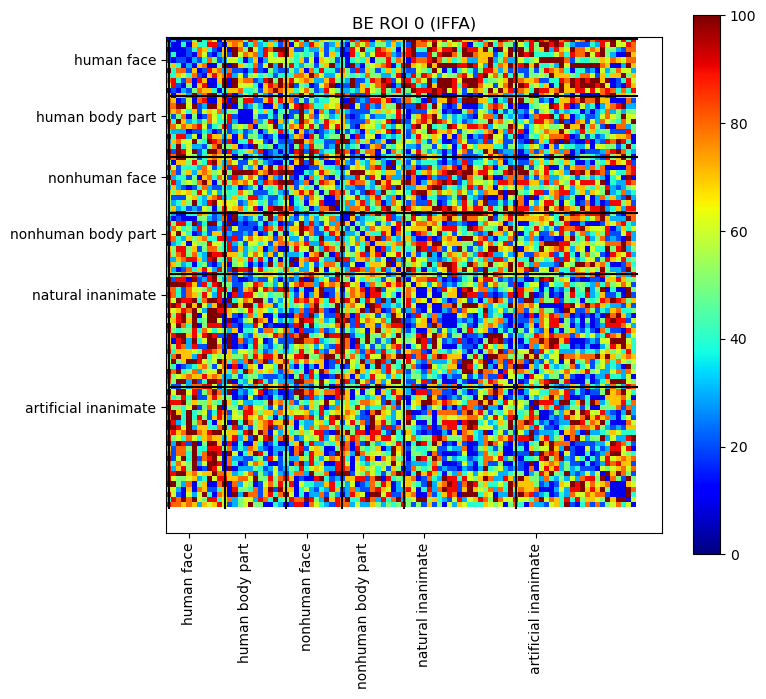

In [9]:
plot_rdm(human_rdms[0,0], title="BE ROI 0 (lFFA)")

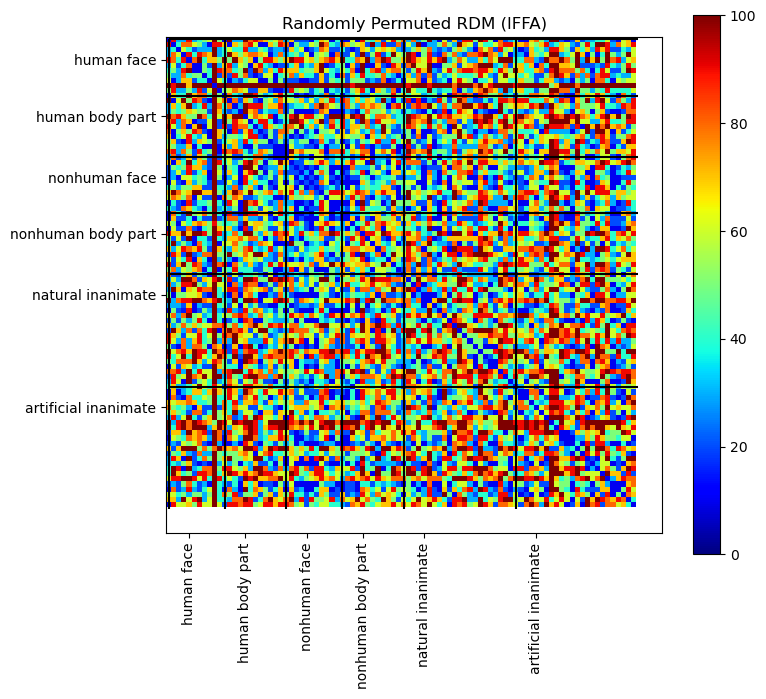

In [14]:
plot_rdm(human_perm_data['lffa'][34], title="Randomly Permuted RDM (lFFA)")

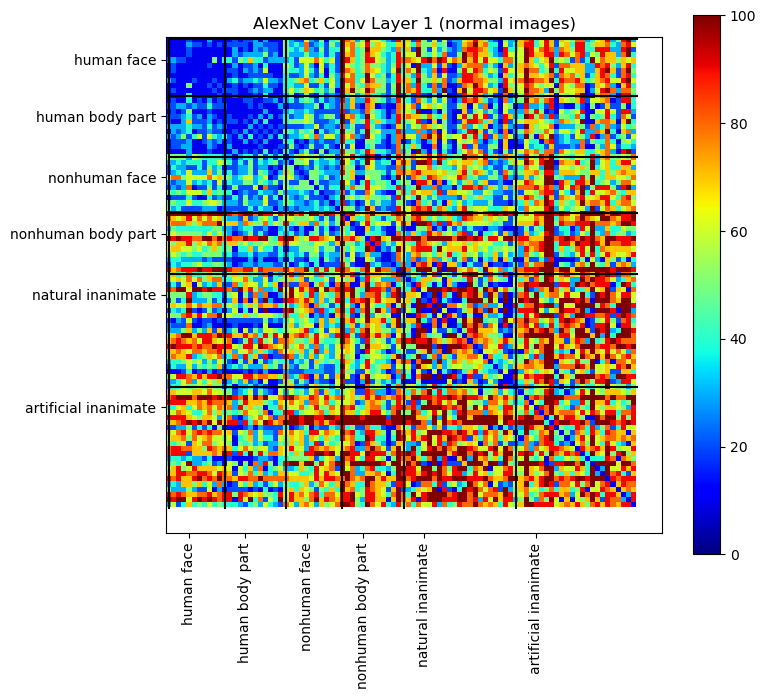

In [10]:
plot_rdm(alexnet_rdms[0,0], title="AlexNet Conv Layer 1 (normal images)")

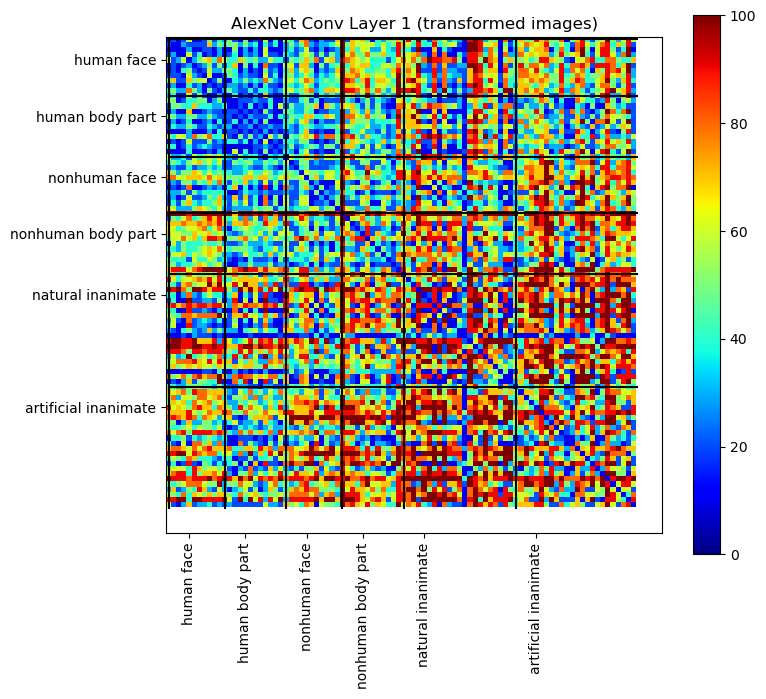

In [11]:
plot_rdm(alexnet_rdms[1,0], title="AlexNet Conv Layer 1 (transformed images)")

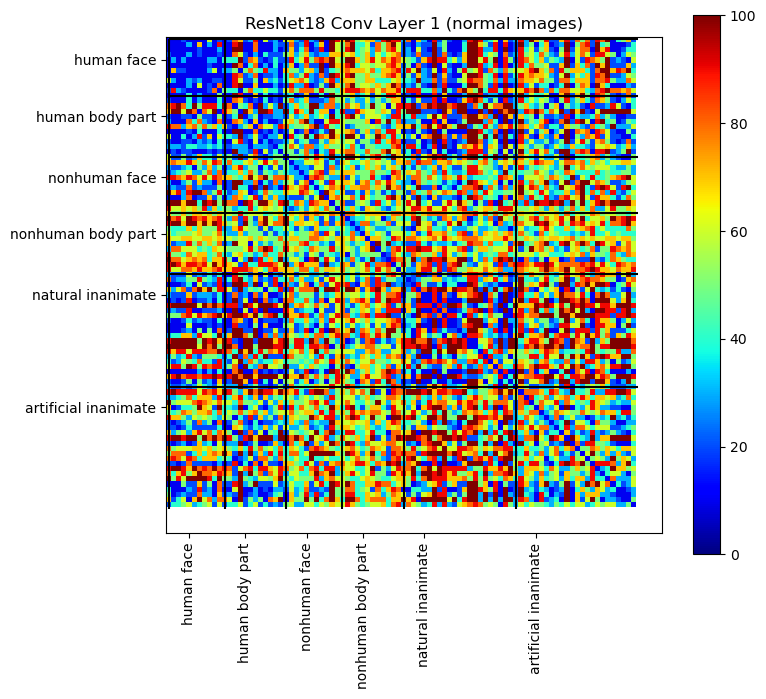

In [12]:
plot_rdm(rn18_rdms[0,0], title="ResNet18 Conv Layer 1 (normal images)")

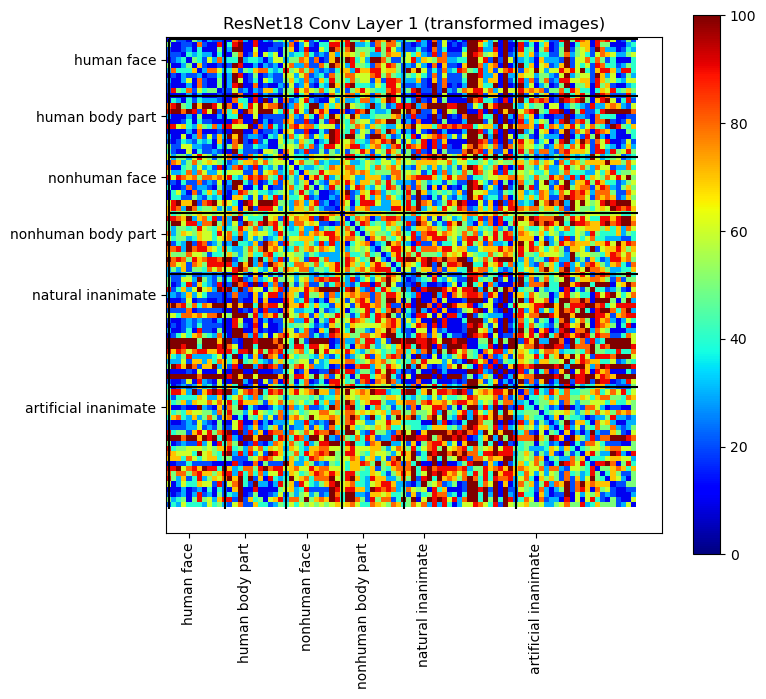

In [13]:
plot_rdm(rn18_rdms[1,0], title="ResNet18 Conv Layer 1 (transformed images)")

# Spearman Rank Correlation

Doing a kind of preliminary analysis for the Assignment 4 presentation:

Look at AlexNet layer activations. 

For each ROI, look at the average Spearman rank correlation between the AlexNet layer activation and all of the subjects.

Plot this as a bar graph for each of the layers. 

## AlexNet

In [17]:
alexnet_srcs = np.zeros((alexnet_rdms.shape[1], 4, 4)) # first dim (alexnet layer), second dim (ROI), third dim (subject)

# iterate through alexnet layers
for i in range(alexnet_rdms.shape[1]):
    layer_rdm = alexnet_rdms[1, i]

    # iterate through rois
    for roi in ROIS:

        # iterate through subjects
        for subj, _ in enumerate(SUBJECTS):

            # get subject RDM
            subj_rdm = human_rdms[roi, subj]
            
            # calculate spearman correlation
            res = spearmanr(layer_rdm, subj_rdm, axis=None)

            alexnet_srcs[i, roi, subj] = res.statistic

In [18]:
# get averages for each layer
alexnet_layer_avgs = np.mean(alexnet_srcs, axis=2)

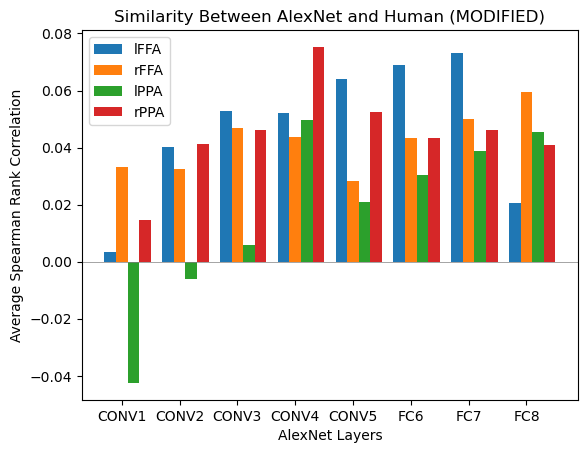

In [20]:
# plot the different layers/regions
x = np.arange(alexnet_layer_avgs.shape[0])
alexnet_layer_names = ['CONV1', 'CONV2', 'CONV3', 'CONV4', 'CONV5', 'FC6', 'FC7', 'FC8']

plt.bar(x - 0.2, alexnet_layer_avgs[:, 0], 0.2, label = 'lFFA')
plt.bar(x, alexnet_layer_avgs[:, 1], 0.2, label = 'rFFA')
plt.bar(x + 0.2, alexnet_layer_avgs[:, 2], 0.2, label = 'lPPA')
plt.bar(x + 0.4, alexnet_layer_avgs[:, 3], 0.2, label = 'rPPA')


plt.axhline(y=0, color='gray', linewidth=0.5, linestyle='-')
plt.xticks(x, alexnet_layer_names)
plt.xlabel("AlexNet Layers")
plt.ylabel("Average Spearman Rank Correlation")
plt.title("Similarity Between AlexNet and Human (MODIFIED)")
plt.legend()
plt.show()

## ResNet18

In [21]:
rn18_srcs = np.zeros((rn18_rdms.shape[1], 4, 4)) # first dim (resnet layer), second dim (ROI), third dim (subject)

# iterate through alexnet layers
for i in range(rn18_rdms.shape[1]):
    layer_rdm = rn18_rdms[1, i]

    # iterate through rois
    for roi in ROIS:

        # iterate through subjects
        for subj, _ in enumerate(SUBJECTS):

            # get subject RDM
            subj_rdm = human_rdms[roi, subj]
            
            # calculate spearman correlation
            res = spearmanr(layer_rdm, subj_rdm, axis=None)

            rn18_srcs[i, roi, subj] = res.statistic

# get averages for each layer
rn18_layer_avgs = np.mean(rn18_srcs, axis=2)

In [22]:
rn18_layer_names = ['C1',
                    'C2',
                    'C3',
                    'C4',
                    'C5',
                    'C6',
                    'C7',
                    'C8',
                    'C9',
                    'C10',
                    'C11',
                    'C12',
                    'C13',
                    'C14',
                    'C15',
                    'C16',
                    'C17',
                    'C18',
                    'C19',
                    'C20',
                    'FC21',]

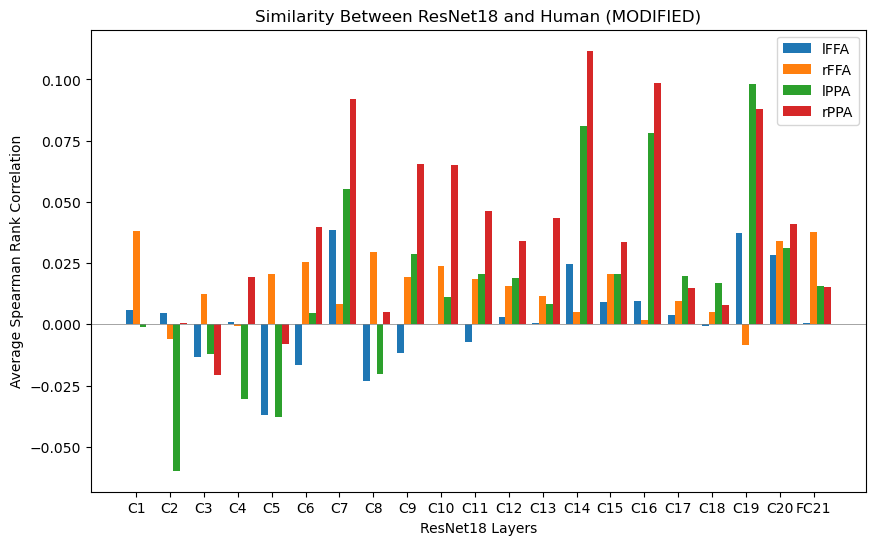

In [24]:
# plot the different layers/regions
plt.figure(figsize=(10,6))
x = np.arange(rn18_layer_avgs.shape[0])

plt.bar(x - 0.2, rn18_layer_avgs[:, 0], 0.2, label = 'lFFA')
plt.bar(x, rn18_layer_avgs[:, 1], 0.2, label = 'rFFA')
plt.bar(x + 0.2, rn18_layer_avgs[:, 2], 0.2, label = 'lPPA')
plt.bar(x + 0.4, rn18_layer_avgs[:, 3], 0.2, label = 'rPPA')


plt.axhline(y=0, color='gray', linewidth=0.5, linestyle='-')
plt.xticks(x, rn18_layer_names)
plt.xlabel("ResNet18 Layers")
plt.ylabel("Average Spearman Rank Correlation")
plt.title("Similarity Between ResNet18 and Human (MODIFIED)")
plt.legend()
plt.show()